In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [4]:
from gambit.db import load_db_from_dir
from gambit.db.models import *
from gambit.metric import jaccarddist_matrix

## DB

In [5]:
db = load_db_from_dir('/home/jared/projects/gambit/data/databases/refseq-curated/1.0-beta2/')

In [6]:
root = db.session.query(Taxon).get(1862)

In [7]:
leaves = list(root.leaves())

In [8]:
_gid_to_index = {g.genome_id: i for i, g in enumerate(db.genomes)}

_indices = []
leaf_labels = []

for i, leaf in enumerate(leaves):
    for g in leaf.genomes:
        _indices.append(_gid_to_index[g.genome_id])
        leaf_labels.append(i)
        
leaf_labels = np.asarray(leaf_labels)
sigs = db.signatures[_indices]

In [9]:
dmat = jaccarddist_matrix(sigs, sigs, chunksize=500, progress=True)

  2%|▏         | 580000/23804641 [00:08<05:58, 64840.53it/s] 


KeyboardInterrupt: 

In [ ]:
leaf_genome_indices = [np.flatnonzero(leaf_labels==i) for i in range(len(leaves))]

In [ ]:
list(map(len, leaf_genome_indices))

In [ ]:
ps = [(taxon.id, taxon.name, taxon.genomes.count()) for taxon in db.session.query(Taxon)]

In [ ]:
ps.sort(key=lambda tup: tup[-1], reverse=True)

In [ ]:
ps[:20]

In [ ]:
db.session.query(Taxon).filter_by(name='Mycobacterium').one().children

In [ ]:
sorted([(taxon.id, taxon.name, taxon.distance_threshold, taxon.genomes.count()) for taxon in _], key=lambda tup: tup[-1])

## ?

In [10]:
leaves2 = [db.session.query(Taxon).get(id) for id in [1403, 1406, 1407]]

In [11]:
[(t.name, t.distance_threshold) for t in leaves2]

[('Streptococcus suis', 0.9232066869735718),
 ('Streptococcus agalactiae', 0.468765377998352),
 ('Streptococcus mutans', 0.3813463747501373)]

In [12]:
nleaves2 = len(leaves2)

In [13]:
_indices2 = []
leaf_labels2 = []

for i, leaf in enumerate(leaves2):
    for g in leaf.genomes:
        _indices2.append(_gid_to_index[g.genome_id])
        leaf_labels2.append(i)
        
leaf_labels2 = np.asarray(leaf_labels2)
sigs2 = db.signatures[_indices2]

In [14]:
dmat2 = jaccarddist_matrix(sigs2, sigs2, chunksize=500, progress=True)

100%|██████████| 2509056/2509056 [00:29<00:00, 86404.44it/s] 


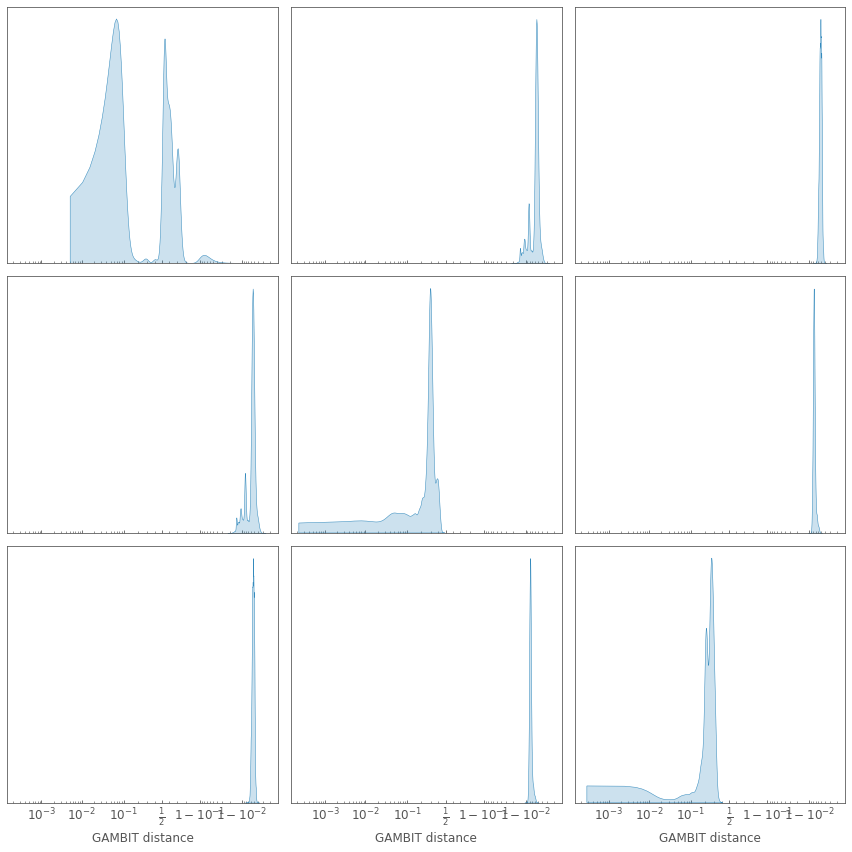

In [16]:
fig, axes = plt.subplots(nleaves2, nleaves2, figsize=(12, 12), sharex=True)


for i, l1 in enumerate(leaves2):
    for j, l2 in enumerate(leaves2):
        ax = axes[i, j]
        
        ds = dmat2[np.ix_(leaf_labels2==i, leaf_labels2==j)]
        if i == j:
            ds = ds[np.tril_indices_from(ds)]
        else:
            ds = ds.flatten()
            
        ax.yaxis.set_visible(False)
        # ax.hist(ds)
        sns.kdeplot(x=ds, ax=ax, fill=True)
        
        # for k in {i, j}:
            # ax.axvline(leaves2[k].distance_threshold, ls='dashed', color='green')
            
        ax.set_xlabel('GAMBIT distance')
        ax.grid(False)
        ax.set_xscale('logit')
        
# for i, leaf in enumerate(leaves2):
#     axes[i, 0].set_ylabel(leaf.name)
#     axes[-1, j].set_xlabel(leaf.name)
        
fig.tight_layout()